# Development of an Automated Daily Trading System

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import os

## Data Loading and Preparation

### Environment Preparation

In [2]:
#We create the object from the previously defined Class PySimFin
from pysimfin import PySimFin

pymsimfin = PySimFin()

In [3]:
#DF containing all the different companies with available information
companies_df = pd.read_csv('./data/raw/us-companies.csv', sep=';', index_col=0)
companies_df = companies_df[~companies_df.index.isna()]
companies_df.head()

,SimFinId,Company Name,IndustryId,ISIN,End of financial year (month),Number Employees,Business Summary,Market,CIK,Main Currency
Ticker,,,,,,,,,,
A,45846,AGILENT TECHNOLOGIES INC,106001.0,US00846U1016,10.0,16400.0,Agilent Technologies Inc is engaged in life sc...,us,1090872.0,USD
A21,1333027,Li Auto Inc.,NaN,NaN,12.0,NaN,NaN,us,1791706.0,USD
AA,367153,Alcoa Corp,110004.0,US0138721065,12.0,12900.0,Alcoa Corp is an integrated aluminum company. ...,us,1675149.0,USD
AAC,7962652,Ares Acquisition Corporation,104002.0,US0003071083,12.0,NaN,Ares Acquisition Corporation does not have sig...,us,1829432.0,USD
AACI,11820349,Armada Acquisition Corp. I,104002.0,US04208V1035,9.0,NaN,Armada Acquisition Corp. I focuses on effectin...,us,1844817.0,USD


In [4]:
#Fetching share prices using the PymSimFin Object - get_share_prices method
zip_path = "data/raw/us-shareprices-daily.csv.zip"
extract_to = "data/raw/"

# Unzip the file if not already extracted
csv_file = os.path.join(extract_to, "us-shareprices-daily.csv")
if not os.path.exists(csv_file):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

shareprices_df = pd.read_csv('./data/raw/us-shareprices-daily.csv', sep=';', parse_dates=['Date'], index_col=0)
shareprices_df = shareprices_df[shareprices_df.index=='TSLA']
shareprices_df = shareprices_df.set_index('Date', drop=True)

In [5]:
#Evaluating the null values per column
print('Percent of Null Values Per Category:\n')
print(shareprices_df.isna().sum()/len(shareprices_df))

Percent of Null Values Per Category:

SimFinId              0.0
Open                  0.0
High                  0.0
Low                   0.0
Close                 0.0
Adj. Close            0.0
Volume                0.0
Dividend              1.0
Shares Outstanding    0.0
dtype: float64


In [56]:
shareprices_df.columns

Index(['SimFinId', 'Open', 'High', 'Low', 'Close', 'Adj. Close', 'Volume',
       'Dividend', 'Shares Outstanding'],
      dtype='object')

In [57]:
# Drop the columns that have null values and aren't useful
shareprices_df = shareprices_df.drop(columns=['Dividend','Shares Outstanding', 'SimFinId'])

In [58]:
shareprices_df

,Open,High,Low,Close,Adj. Close,Volume
Date,,,,,,
2019-04-25,17.00,17.27,16.40,16.51,16.51,327740895
2019-04-26,16.43,16.45,15.41,15.68,15.68,335410635
2019-04-29,15.72,16.27,15.48,16.10,16.10,250717140
2019-04-30,16.14,16.28,15.80,15.91,15.91,141969420
2019-05-01,15.92,16.00,15.43,15.60,15.60,160565310
...,...,...,...,...,...,...
2024-03-22,166.69,171.20,166.30,170.83,170.83,75580637
2024-03-25,168.76,175.24,168.73,172.63,172.63,74228615
2024-03-26,178.58,184.25,177.38,177.67,177.67,113186227


**GPT Prompt for Feature Engineering + Next Steps**

Our goal is to use historical daily data from share prices to build a model that:

1) Will predict whether the price will rise or fall
2) Must make predictions daily and predict the one-day-ahead price movement
3) Eventually inform the user on whether they should buy or sell the stock

Our professor who assigned us the project recommended the following approach to processing the data:

1) Feature engineer and create more information with what we already have
2) Assess collinearity and feature importance to reduce the information back down to what's useful
3) Use this engineered dataset with a linear regression model to predict the open or close price based on our set of features

### Feature Engineering

In [59]:
#Creating a function that contains feature creation, for instance ratios, date decomposition, smoothed and exponential averages, Rolling windows, among others

def transformation(df):
    df['Day'] = df.index.day
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['DayOfWeek'] = df.index.day_of_week
    df['Quarter'] = df.index.quarter
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

    def compute_rsi(data, window=14):
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    df['RSI'] = compute_rsi(df['Close'])

    df['Daily_Return'] = df['Close'].pct_change()
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    df['Rolling_Std_10'] = df['Daily_Return'].rolling(window=10).std()
    df['Rolling_Std_20'] = df['Daily_Return'].rolling(window=20).std()
    df['Rolling_Std_50'] = df['Daily_Return'].rolling(window=50).std()

    df['High-Low'] = df['High'] - df['Low']
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))

    df['TrueRange'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
    df['ATR'] = df['TrueRange'].rolling(window=14).mean()

    df['Volume_MA_10'] = df['Volume'].rolling(window=10).mean()
    df['Volume_MA_20'] = df['Volume'].rolling(window=20).mean()

    return df

In [60]:
#Application of Feature Engineering UDF to df
df = transformation(shareprices_df)

In [61]:
#Creation of the Next_Day_Close column which has the information of the Next Day Closing price of the asset
#Furthermore this would be our target variable
df['next_day_close'] = df['Close'].shift(-1)

### Select Features

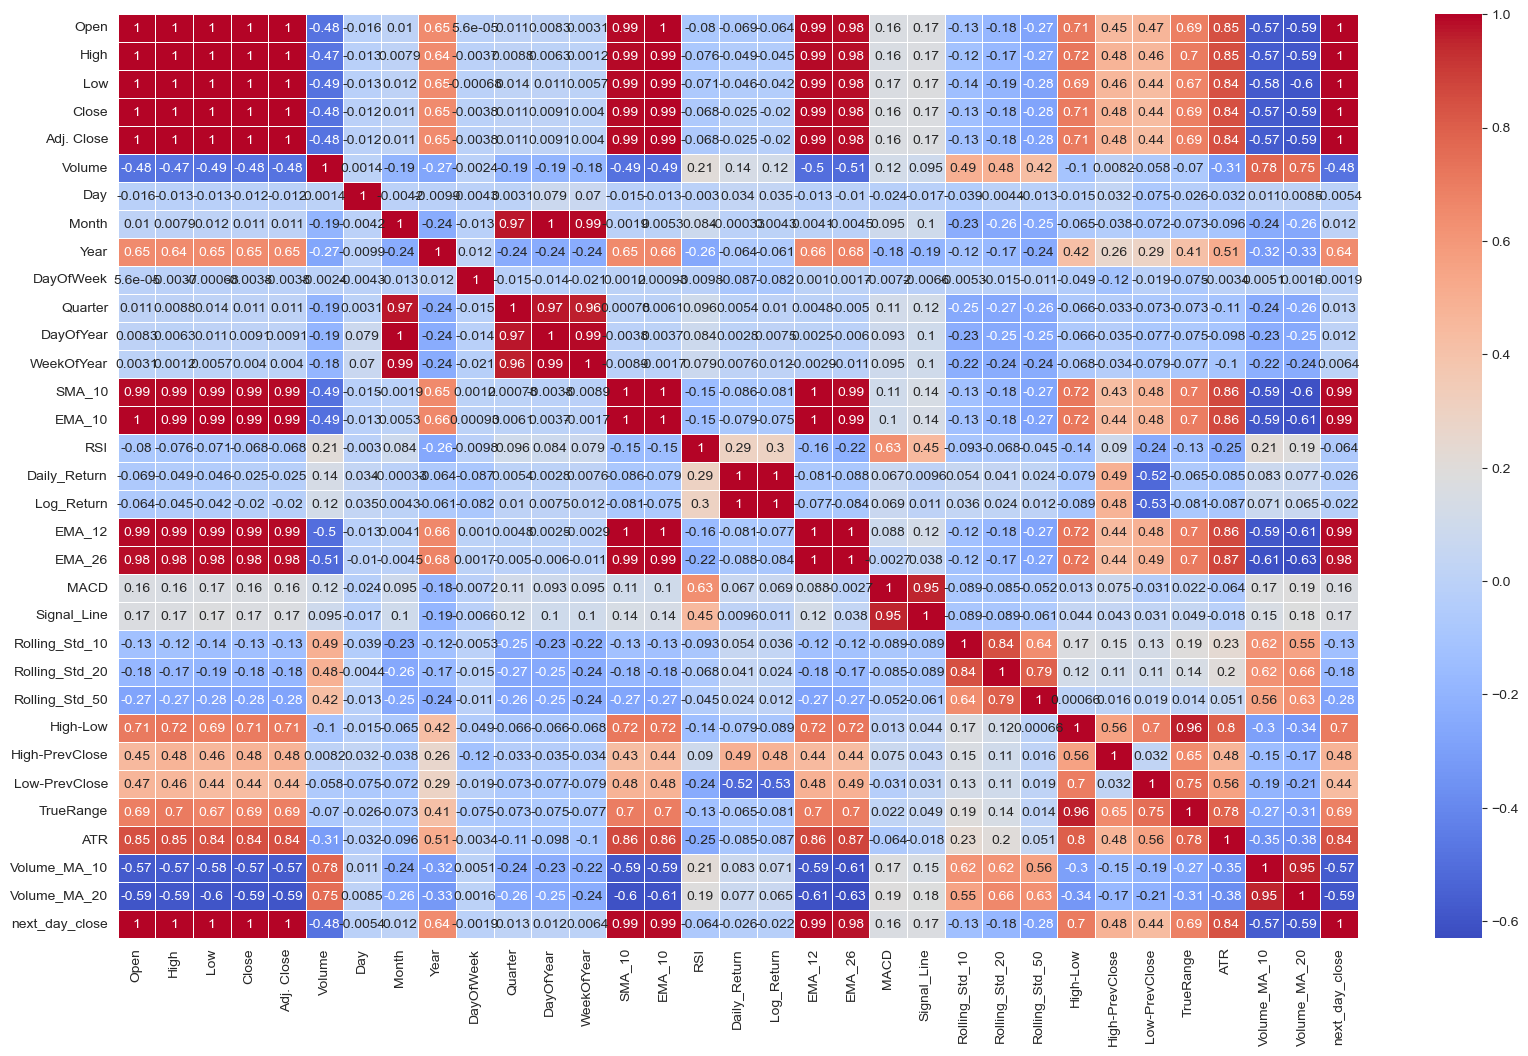

In [62]:
#Analysis of Correlation Matrix (All variables)
plt.figure(figsize=(20,12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

In [63]:
#Some features are created using rolling windows or depend on the information from the original dataset, which may result in null values when the necessary data to derive the new metric is unavailable
df.isna().sum()

Open               0
High               0
Low                0
Close              0
Adj. Close         0
Volume             0
Day                0
Month              0
Year               0
DayOfWeek          0
Quarter            0
DayOfYear          0
WeekOfYear         0
SMA_10             9
EMA_10             0
RSI               13
Daily_Return       1
Log_Return         1
EMA_12             0
EMA_26             0
MACD               0
Signal_Line        0
Rolling_Std_10    10
Rolling_Std_20    20
Rolling_Std_50    50
High-Low           0
High-PrevClose     1
Low-PrevClose      1
TrueRange          0
ATR               13
Volume_MA_10       9
Volume_MA_20      19
next_day_close     1
dtype: int64

In [64]:
cols = list(df.columns)

#Creation of UDF that fills Null Values with median of the column
def values_imputation(df,cols):
    median_values = df[cols].median()
    filled = df[cols].fillna(median_values)
    return filled

df_na_filled = values_imputation(df,cols)

In [65]:
#Determine the target and predictor variables

y = df_na_filled['next_day_close']
X2 = df_na_filled.drop('next_day_close',axis=1).copy()


## Regression Models

### Linear Regression


In [66]:
from sklearn.model_selection import train_test_split
#Separating Training and Test Data

# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 992, Testing samples: 249


In [67]:
from sklearn.linear_model import LinearRegression

# Initialize and train model
model = LinearRegression()
model.fit(X_train, y_train)

# Print coefficients
print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Model Coefficients: [ 1.20679786e-01  1.52458315e-02 -1.74872557e-02  4.18510309e-01
  4.18542970e-01 -9.76157907e-09  3.50002838e-01  8.13815087e+00
  1.93409995e-01  8.32163918e-02  5.53944829e-02 -2.70826588e-01
  4.32388631e-02  7.02030018e-04 -4.06449827e+00  2.69689425e-02
  3.73120765e+02 -3.75569559e+02  3.38062816e+00  7.20964754e-01
  2.65966343e+00 -1.34849148e+00  3.99817010e+01 -4.21070658e+01
 -2.18513949e+01  3.29149982e-02  1.73128293e-02 -1.36443459e-01
  2.26757592e-02  1.18838652e-02 -4.35207830e-09  1.55797429e-08]
Intercept: -401.07979473321046


In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict on test set
y_pred_lr = model.predict(X_test)

# Compute evaluation metrics
mae = mean_absolute_error(y_test, y_pred_lr)
mse = mean_squared_error(y_test, y_pred_lr)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_lr)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 4.9078
Mean Squared Error (MSE): 46.8318
Root Mean Squared Error (RMSE): 6.8434
R² Score: 0.9950


### XGBoost Model

**GPT Prompt for XGBoost Model**


Can you show me how I could use the same data I have to feed it to an XGBoost model and evaluate its performance compared to the linear regression?

In [69]:
import xgboost as xgb

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",  # Standard regression objective
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=5,  # Depth of each tree (controls complexity)
    subsample=0.8,  # Fraction of samples used per tree
    colsample_bytree=0.8,  # Fraction of features per tree
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)


### LinReg vs XGB: Model Comparison

In [70]:
# Compute metrics for both models
models = {
    "Linear Regression": y_pred_lr,
    "XGBoost": y_pred_xgb
}

for model_name, y_pred in models.items():
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"🔹 {model_name} Performance:")
    print(f"   - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"   - Mean Squared Error (MSE): {mse:.4f}")
    print(f"   - Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"   - R² Score: {r2:.4f}")
    print("-" * 50)


🔹 Linear Regression Performance:
   - Mean Absolute Error (MAE): 4.9078
   - Mean Squared Error (MSE): 46.8318
   - Root Mean Squared Error (RMSE): 6.8434
   - R² Score: 0.9950
--------------------------------------------------
🔹 XGBoost Performance:
   - Mean Absolute Error (MAE): 5.3014
   - Mean Squared Error (MSE): 53.7831
   - Root Mean Squared Error (RMSE): 7.3337
   - R² Score: 0.9943
--------------------------------------------------


Both models, Linear Regression and XGBoost had a good performance. However given that Linear Regression is highly sensitive to multicolinearity we decided to work with XGBoost as this is robust when there is high correlation between predictors. 

In our case, the majority of features may be correlated between each other as they all derive from the limited set of originally available features. Hence, why we chose to keep our training with XGBoost and Feature Importance

### GPT Prompt for Grid Search
Can you write me a small bit of code to use grid search to fine tune the parameters of my XGBoost model? I want to see if I can improve the performance of the model just a bit more

In [71]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [250, 300, 350],  # Number of trees
    'learning_rate': [0.05, 0.1, 0.15],  # Step size shrinkage
    'max_depth': [3, 5, 7],  # Tree depth
    'subsample': [0.7, 0.8, 1.0],  # Fraction of samples per tree
    'colsample_bytree': [0.8, 0.9, 1.0]  # Fraction of features per tree
}

# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='r2',  # Optimize for R^2 score
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit Grid Search on training data
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Get best model
best_xgb = grid_search.best_estimator_

# Predict on test set
y_pred_xgb_tuned = best_xgb.predict(X_test)

# Evaluate tuned model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred_xgb_tuned)
mse = mean_squared_error(y_test, y_pred_xgb_tuned)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_xgb_tuned)

# Print evaluation metrics
print(f"🔹 Tuned XGBoost Performance:")
print(f"   - Mean Absolute Error (MAE): {mae:.4f}")
print(f"   - Mean Squared Error (MSE): {mse:.4f}")
print(f"   - Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"   - R² Score: {r2:.4f}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.7}
🔹 Tuned XGBoost Performance:
   - Mean Absolute Error (MAE): 5.2917
   - Mean Squared Error (MSE): 54.3967
   - Root Mean Squared Error (RMSE): 7.3754
   - R² Score: 0.9942


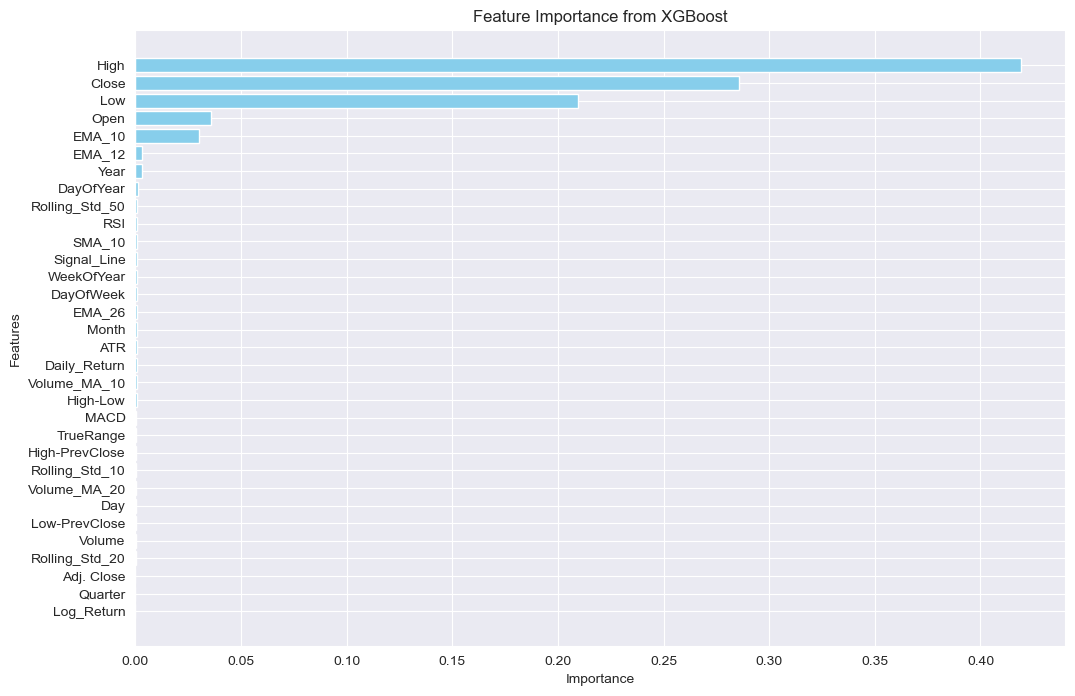

In [72]:
#Plot of Feature Importance of the trained model

import matplotlib.pyplot as plt
import numpy as np

feature_importances = best_xgb.feature_importances_ #Extraction of Features with higher Information Gain 
feature_names = X_train.columns

importances_df = pd.DataFrame({
    'Features': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importances_df['Features'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance from XGBoost')
plt.gca().invert_yaxis()
plt.show()



### Optimized XGBoost

In [73]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

#Creation of a new Optimized XGBoost Model that includes only the most relevant Features (as concluded from the Feature Importance Plot)

important_features = ['Low', 'Close', 'High', 'Open', 'EMA_10', 'EMA_12', 'Year']  #Definition of most important columns
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]

param_grid = {
    'n_estimators': [250, 300, 350],  # Number of trees
    'learning_rate': [0.05, 0.1, 0.15],  # Step size shrinkage
    'max_depth': [3, 5, 7],  # Tree depth
    'subsample': [0.7, 0.8, 1.0],  # Fraction of samples per tree
    'colsample_bytree': [0.8, 0.9, 1.0]  # Fraction of features per tree
}

model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)  #Creation of the model Object

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)  #Grid Search with R2, and previously stated parameters to test)
grid_search.fit(X_train_reduced, y_train)

best_model = grid_search.best_estimator_  #Extraction of best model
y_pred_train = best_model.predict(X_train_reduced) 
y_pred_test = best_model.predict(X_test_reduced)

#Evaluation of metrics (model performace)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print("Train Mean Squared Error:", mse_train)
print("Test Mean Squared Error:", mse_test)
print("Train R2 Score:", r2_train)
print("Test R2 Score:", r2_test)
print("Train MAPE:", mape_train)
print("Test MAPE:", mape_test)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation R2 score:", grid_search.best_score_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Train Mean Squared Error: 34.90985960270264
Test Mean Squared Error: 51.681569204592236
Train R2 Score: 0.9967068450137747
Test R2 Score: 0.9944820235131692
Train MAPE: 0.026829924753530066
Test MAPE: 0.03205604885854469
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.7}
Best Cross-validation R2 score: 0.9926358710127471


In [74]:
#Definition of Best Optimized Model

new_best_xgb = best_model

## Making the Prediction

In [75]:
#Simulation of how the prediction will be done when integrated in Streamlit
#Defining a simulated DF with the chosen company and data ranges

df_to_pred = pymsimfin.get_share_prices('AMZN','2022-03-01','2024-03-31')

In [76]:
#Preparation of the data to be in a suitable format for prediction
df_to_pred =df_to_pred.drop(columns=['Dividend Paid','Common Shares Outstanding'])
df_to_pred.rename(columns={
    'Opening Price':'Open', 'Highest Price':'High','Lowest Price':'Low','Last Closing Price':'Close','Trading Volume':'Volume'
    
},inplace=True)
df_to_pred_original = df_to_pred.copy()

In [77]:
#Application of the same Feature Engineering function to the new Dataset - the model has to receive the same information as it had when trained, hence the need to apply any transformation or feature creation our df_to_pred DF

df_to_pred = transformation(df_to_pred)

In [78]:
#Nulls treatment
df_to_pred.drop('Ticker',axis=1,inplace=True)
df_to_pred = values_imputation(df_to_pred,df_to_pred.columns)


In [79]:
#Filtering the DF to consider only the features with which our Optimized model was trained
df_to_pred=df_to_pred[important_features]

In [80]:
df_to_pred

,Low,Close,High,Open,EMA_10,EMA_12,Year
Date,,,,,,,
2022-03-01,149.98,151.14,154.10,152.73,151.140000,151.140000,2022
2022-03-02,148.75,152.05,153.00,150.85,151.305455,151.280000,2022
2022-03-03,146.86,147.90,153.93,153.53,150.686281,150.760000,2022
2022-03-04,143.81,145.64,147.85,147.16,149.768775,149.972308,2022
2022-03-07,137.42,137.45,146.09,145.44,147.528998,148.045799,2022
...,...,...,...,...,...,...,...
2024-03-22,176.75,178.87,179.25,177.75,176.743082,176.456508,2024
2024-03-25,177.24,179.71,180.99,178.01,177.282522,176.957045,2024
2024-03-26,177.95,178.30,180.45,180.15,177.467518,177.163654,2024


In [81]:
#Prediction of Next_Day_Close 
predicted_prices = new_best_xgb.predict(df_to_pred)
df_to_pred_original['Predicted_Next_Day_Close'] = predicted_prices
df_to_pred_original = df_to_pred_original[['Close','Predicted_Next_Day_Close',]]
df_to_pred_original

,Close,Predicted_Next_Day_Close
Date,,
2022-03-01,151.14,151.908081
2022-03-02,152.05,148.734360
2022-03-03,147.90,149.233078
2022-03-04,145.64,146.063293
2022-03-07,137.45,136.151993
...,...,...
2024-03-22,178.87,181.653427
2024-03-25,179.71,181.653427
2024-03-26,178.30,180.207428


In [83]:
sf = PySimFin()
start = sf.get_available_dates('TSLA')[0]
start

'2018-03-26'

In [84]:
pd.to_datetime(start)

Timestamp('2018-03-26 00:00:00')